In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

import warnings
# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pickle

In [2]:
df_model2 = pd.read_csv('/Users/bhushanborude/Desktop/Projects/Python/Python for Machine Learning & Data Science Masterclass/FINN/merged_df.csv')

# Convert delay_bool to numeric:
df_model2['delay_bool'] = df_model2['delay_bool'].astype(int)

# Drop irrelevant or ID columns:
df_model2 = df_model2.drop(columns=['invoice_id','invoice_status', 'deal_id', 'invoice_date', 'invoice_due_date', 'paid_date', 'dunning_status', 'delay_in_days', 'due_day_group', 'customer_id', 
                                  'deal_signed_date', 'deal_deposit_amount', 'postal_code', 'date_of_birth','invoice_amount_group', 'age_group', 'deal_monthly_amount_group','deal_term_group', 'schufa_group'])

df_model2.dropna(inplace=True)

In [3]:
# Feature selection
X = df_model2.drop('delay_bool', axis=1)
y = df_model2['delay_bool']

categorical_cols = ['invoice_type', 'invoice_month', 'loyalty_status', 'deposit', 'due_day']
numeric_cols = ['invoice_amount', 'deal_term', 'deal_monthly_amount', 'schufa_score','age']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)
# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Logistic Regression

In [4]:
# Create Logistic Regression model
lr_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, 
                                      class_weight={0: 1, 1: 16}, #to handle imbalance
                                      random_state=42))
])
# Train the model
lr_model.fit(X_train, y_train)

# Predictions
y_proba_lr = lr_model.predict_proba(X_test)[:, 1]
threshold = 0.4  
y_pred_lr = (y_proba_lr >= threshold).astype(int)

# Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred_lr))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba_lr))

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.67      0.79      2059
           1       0.16      0.81      0.26       156

    accuracy                           0.68      2215
   macro avg       0.57      0.74      0.53      2215
weighted avg       0.92      0.68      0.76      2215

Confusion Matrix:
 [[1377  682]
 [  29  127]]
ROC AUC Score: 0.8212600092153274


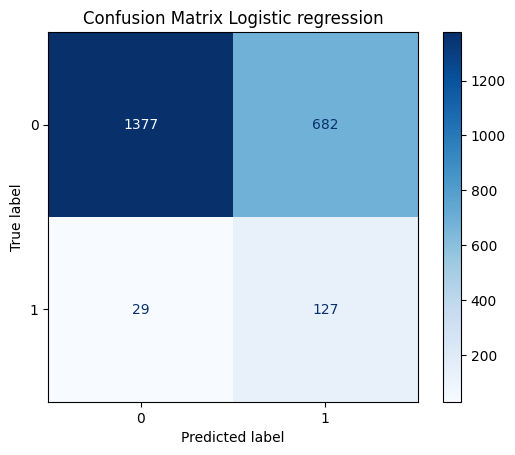

In [5]:
cm = confusion_matrix(y_test, y_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix Logistic regression')
plt.show()

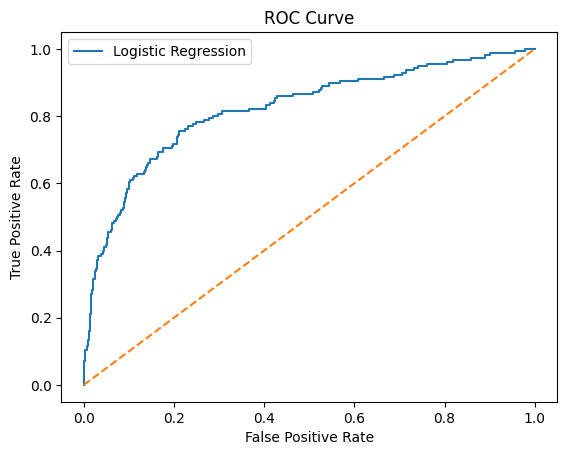

In [6]:
fpr, tpr, _ = roc_curve(y_test, y_proba_lr)
plt.plot(fpr, tpr, label='Logistic Regression')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

## Random Forest

In [7]:
# Create Random Forest model
rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=1000,
                                          class_weight={0: 1, 1: 16},  #to handle imbalance
                                          random_state=42))
])

# Train the model
rf_model.fit(X_train, y_train)

# Predictions
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]  # Probabilities for class 1 (delayed)
threshold = 0.3 #Apply custom threshold (e.g., 0.3 instead of 0.5)
y_pred_rf = (y_proba_rf >= threshold).astype(int)

# Evaluation
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba_rf))

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      2059
           1       0.56      0.57      0.56       156

    accuracy                           0.94      2215
   macro avg       0.76      0.77      0.76      2215
weighted avg       0.94      0.94      0.94      2215

Confusion Matrix:
 [[1988   71]
 [  67   89]]
ROC AUC Score: 0.908413344790227


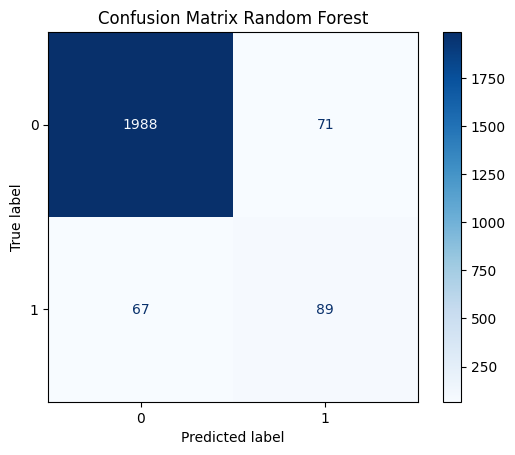

In [8]:
cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix Random Forest')
plt.show()

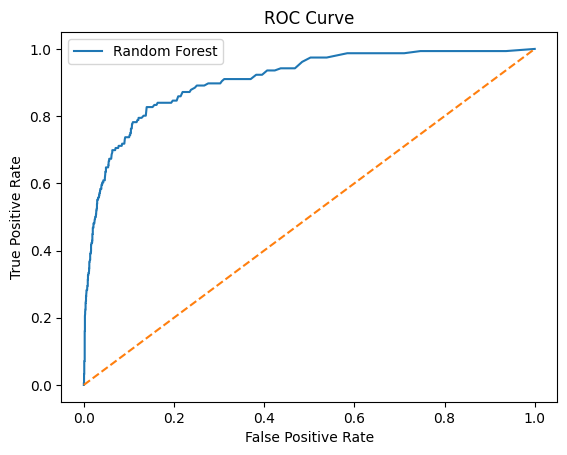

In [9]:
fpr, tpr, _ = roc_curve(y_test, y_proba_rf)
plt.plot(fpr, tpr, label='Random Forest')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

## CatBoost

In [10]:
# Create CatBoost model
cat_model = CatBoostClassifier(
    verbose=0,
    random_state=42,
    iterations=10000,
    class_weights=[1, 16]  #to handle imbalance
)

# Train model using original categorical columns (no one-hot needed)
cat_model.fit(X_train, y_train, cat_features=categorical_cols)

# Predictions
y_proba_cb = cat_model.predict_proba(X_test)[:, 1]
threshold = 0.3
y_pred_cb = (y_proba_cb >= threshold).astype(int)

# Evaluation
print("CatBoost Classification Report:\n", classification_report(y_test, y_pred_cb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_cb))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba_cb))

CatBoost Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.85      0.91      2059
           1       0.29      0.80      0.43       156

    accuracy                           0.85      2215
   macro avg       0.64      0.83      0.67      2215
weighted avg       0.93      0.85      0.88      2215

Confusion Matrix:
 [[1752  307]
 [  31  125]]
ROC AUC Score: 0.8820033374428712


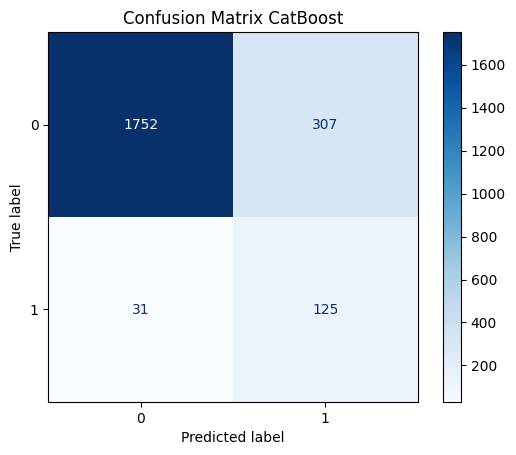

In [11]:
cm = confusion_matrix(y_test, y_pred_cb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix CatBoost')
plt.show()

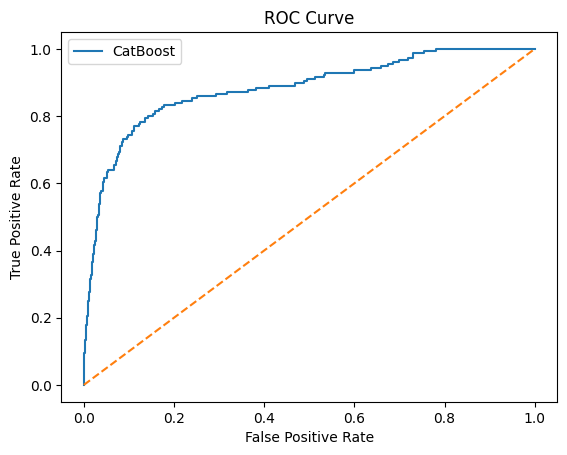

In [12]:
fpr, tpr, _ = roc_curve(y_test, y_proba_cb)
plt.plot(fpr, tpr, label='CatBoost')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [13]:
# Save the model
with open('cat_model.pkl', 'wb') as file:
    pickle.dump(cat_model, file)

In [17]:
X_test.to_csv('/Users/bhushanborude/Desktop/Projects/Python/Python for Machine Learning & Data Science Masterclass/FINN/Test.csv', index=False)